In [4]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

(array([19358., 19417., 19478., 19539., 19601., 19662., 19723.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

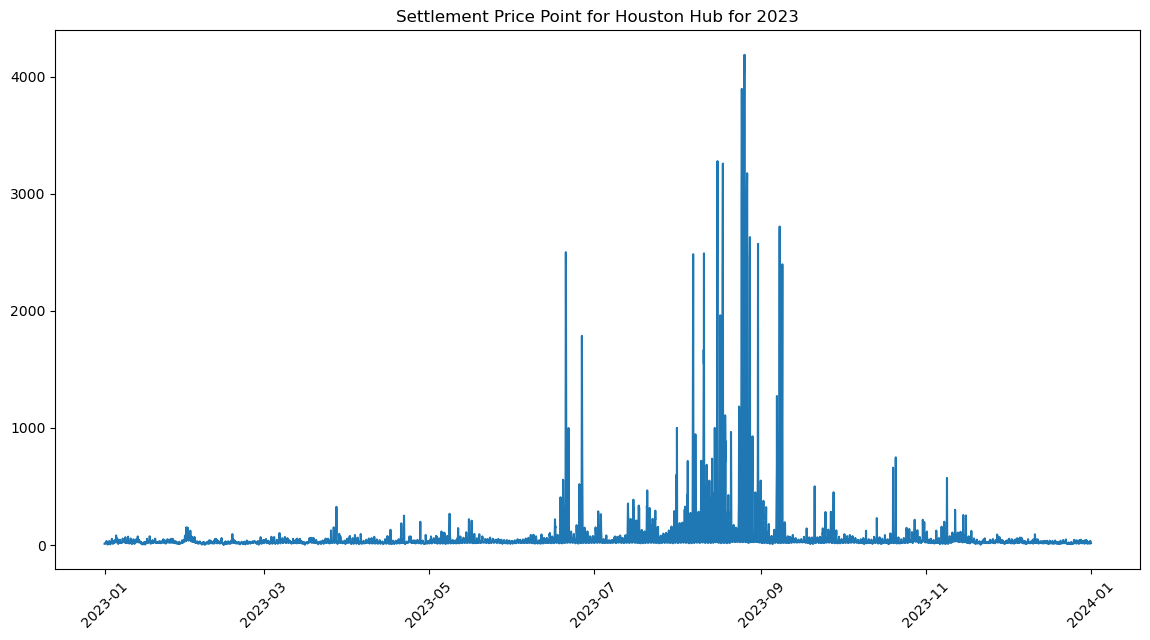

In [2]:
#Import price data
df_price_all_years = pd.read_csv("data/price/price_2018_2024.csv")
df_price_all_years["datetime"] = pd.to_datetime(df_price_all_years.datetime)

#Filter for Houston in 2023 and reset index
df_price_houston = df_price_all_years[df_price_all_years["Settlement Point"] == "HB_HOUSTON"].reset_index(drop=True)
df_price_houston_2023 = df_price_houston[df_price_houston.datetime.dt.year == 2023].drop(columns=["Repeated Hour Flag","Settlement Point"])
df_price_houston_2023 = df_price_houston_2023.reset_index(drop=True)

#Plot the price over 2023 for Houston
plt.figure(figsize=(14,7))
plt.title("Settlement Price Point for Houston Hub for 2023")
plt.plot(df_price_houston_2023.set_index("datetime"))
plt.xticks(rotation=45)



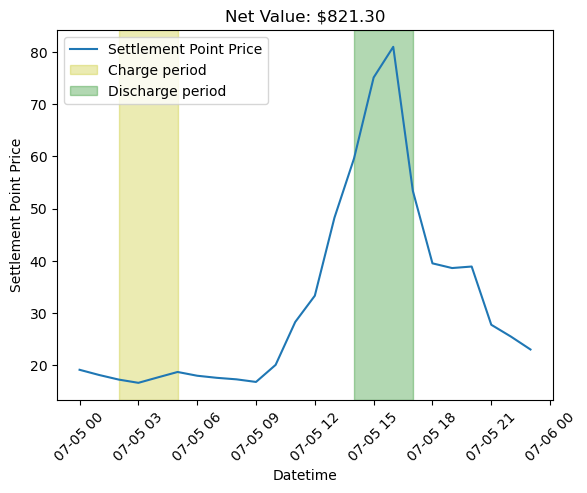

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Sample data
df = df_price_houston

def filter_data(date):
    return df[(df['datetime'] >= pd.to_datetime(date)) & (df['datetime'] < pd.to_datetime(date) + pd.Timedelta(days=1))]

def calculate_battery_value(filtered_df, charge_start_hour, discharge_start_hour, total_charge, charge_rate, discharge_rate):
    charge_time_hours = total_charge / charge_rate
    discharge_time_hours = total_charge / discharge_rate

    charge_period_prices = filtered_df.iloc[charge_start_hour:charge_start_hour + int(charge_time_hours)]['Settlement Point Price']
    discharge_period_prices = filtered_df.iloc[discharge_start_hour:discharge_start_hour + int(discharge_time_hours)]['Settlement Point Price']
    
    charge_value = (charge_period_prices * charge_rate).sum()
    discharge_value = (discharge_period_prices * discharge_rate).sum()
    
    net_value = discharge_value - charge_value
    earnings = discharge_value
    return net_value, earnings, charge_time_hours, discharge_time_hours

def find_lowest_charge_period(filtered_df, charge_time_hours):
    min_sum = float('inf')
    min_index = 0
    for i in range(len(filtered_df) - int(charge_time_hours)):
        current_sum = filtered_df['Settlement Point Price'].iloc[i:i + int(charge_time_hours)].sum()
        if current_sum < min_sum:
            min_sum = current_sum
            min_index = i
    return min_index

def find_highest_discharge_period(filtered_df, discharge_time_hours):
    max_sum = float('-inf')
    max_index = 0
    for i in range(len(filtered_df) - int(discharge_time_hours)):
        current_sum = filtered_df['Settlement Point Price'].iloc[i:i + int(discharge_time_hours)].sum()
        if current_sum > max_sum:
            max_sum = current_sum
            max_index = i
    return max_index

def update_plot(button):
    clear_output(wait=True)
    selected_date = date_picker.value
    total_charge = total_charge_input.value
    charge_rate = charge_rate_slider.value
    discharge_rate = discharge_rate_slider.value
    charge_start_hour = charge_start_hour_slider.value
    discharge_start_hour = discharge_start_hour_slider.value
    filtered_df = filter_data(selected_date)
    
    if len(filtered_df) == 0:
        print("No data available for the selected date.")
        return
    
    net_value, earnings, charge_time_hours, discharge_time_hours = calculate_battery_value(filtered_df, charge_start_hour, discharge_start_hour, total_charge, charge_rate, discharge_rate)
    
    fig, ax = plt.subplots()
    ax.plot(filtered_df['datetime'], filtered_df['Settlement Point Price'], label='Settlement Point Price')
    ax.axvspan(filtered_df.iloc[charge_start_hour]['datetime'], filtered_df.iloc[charge_start_hour + int(charge_time_hours)]['datetime'], color='y', alpha=0.3, label='Charge period')
    ax.axvspan(filtered_df.iloc[discharge_start_hour]['datetime'], filtered_df.iloc[discharge_start_hour + int(discharge_time_hours)]['datetime'], color='g', alpha=0.3, label='Discharge period')
    ax.set_title(f'Net Value: ${net_value:.2f}')
    ax.legend()
    plt.xticks(rotation=45)
    plt.xlabel('Datetime')
    plt.ylabel('Settlement Point Price')
    plt.show()
    
    display(ui)

def update_sliders(change):
    selected_date = date_picker.value
    total_charge = total_charge_input.value
    charge_rate = charge_rate_slider.value
    discharge_rate = discharge_rate_slider.value
    filtered_df = filter_data(selected_date)
    
    charge_time_hours = total_charge / charge_rate
    discharge_time_hours = total_charge / discharge_rate
    
    charge_start_hour = find_lowest_charge_period(filtered_df, charge_time_hours)
    discharge_start_hour = find_highest_discharge_period(filtered_df, discharge_time_hours)
    
    charge_start_hour_slider.value = charge_start_hour
    discharge_start_hour_slider.value = discharge_start_hour

def show_refresh_message(change):
    refresh_label.value = "Data needs to be refreshed."

# Create widgets
date_picker = widgets.DatePicker(
    description='Select Date',
    value=pd.to_datetime('2023-07-23')
)
total_charge_input = widgets.FloatText(value=15, description='Total Charge (kWh):', style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))
charge_rate_slider = widgets.FloatSlider(value=5.0, min=0, max=10, step=0.1, description='Charge Rate (kW):', style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))
discharge_rate_slider = widgets.FloatSlider(value=5.0, min=0, max=10, step=0.1, description='Discharge Rate (kW):', style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))

charge_start_hour_slider = widgets.IntSlider(value=0, min=0, max=20, step=1, description='Charge Start Hour:', style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))
discharge_start_hour_slider = widgets.IntSlider(value=0, min=0, max=20, step=1, description='Discharge Start Hour:', style={'description_width': 'initial'}, layout=widgets.Layout(width='300px'))

refresh_button = widgets.Button(description="Refresh")
refresh_button.on_click(update_plot)

refresh_label = widgets.Label()

date_picker.observe(show_refresh_message, names='value')
total_charge_input.observe(show_refresh_message, names='value')
charge_rate_slider.observe(show_refresh_message, names='value')
discharge_rate_slider.observe(show_refresh_message, names='value')

date_picker.observe(update_sliders, names='value')
total_charge_input.observe(update_sliders, names='value')
charge_rate_slider.observe(update_sliders, names='value')
discharge_rate_slider.observe(update_sliders, names='value')

ui = widgets.VBox([
    date_picker, 
    total_charge_input, 
    charge_rate_slider, 
    discharge_rate_slider, 
    charge_start_hour_slider, 
    discharge_start_hour_slider, 
    refresh_button, 
    refresh_label
])

# Display the widgets
display(ui)
update_sliders(None)
update_plot(None)